# Introduction to Support Vector Machines (SVMs)

The support vector machine is a commonly used approach for engaging in supervised machine learning. In a 
very basic form, we can think of an SVM model as trying to separate two classes of data which are color coded 
in two dimensional scatter plot and we want to separate them with a straight line. And the goal is really to 
find a linear equation that best separates these two classes of data. If we can find an equation that can 
separate the data cleanly, the the classes are considered to be _linearly separable_.

Let's look at a an example of this, and we're going to go to major leage baseball. I'm going to make the problem
a bit easier and cleaner for us for teaching, but we'll see how to deal with some ambiguity later. Now, the MLB
captures a lot of data about pitches, though a fair bit of it is actually inferred data so it's a little unclear
where each element comes from. But my goal is this: can we use pitching data, sepcifically the speed of the ball 
and the amount of spin it has when leaving the pitchers hand, and predict the type of pitch it will be? We'll
make it even a bit easier, and consider just fastballs and cuveballs, and we'll see if this is a problem which
is something that is linearly seperable.

In [3]:
# Let's start with bringing in a couple of module imports for our analysis. The data for this
# is stored in our assets folder as baseball_svm_data.zip, and contains all of the pitching
# data for a single season.

# Our standard data science imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A special module for dealing with zipfiles
import zipfile

# Now we load our dataframe directly from within the zip file -- this is a handy way to deal
# with storing lots of data and not running out of space!
#filename="D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\IntroductiontoMachineLearninginSportsAnalytics\\data\\baseball_svm_data.zip\\"
df=pd.read_csv("D:\\GitHub\\Coursera\\SportsPerformanceAnalytics\\IntroductiontoMachineLearninginSportsAnalytics\\data\\reg_Sep2019.csv")

# Now let's just look at the header of this DataFrame
df.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,player_name,batter,events,description,zone,des,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FS,81.2,-1.0920,6.3157,Jake Faria,435622,run,ball,13.0,Wild pitch by pitcher Jake Faria. Sam Hillia...,...,3,3,3,3,3,3,3,3,Strategic,Strategic
1,FF,90.0,-0.8826,6.4818,Jake Faria,435622,NaN,called_strike,5.0,NaN,...,3,3,3,3,3,3,3,3,Strategic,Strategic
2,SL,83.8,-0.9456,6.2833,Jake Faria,602074,single,hit_into_play_no_out,2.0,Yonathan Daza singles on a bunt ground ball to...,...,3,3,3,3,3,3,3,3,Standard,Standard
3,FF,92.3,-0.8358,6.3745,Jake Faria,602074,NaN,foul,5.0,NaN,...,3,3,3,3,3,3,3,3,Standard,Standard
4,FF,93.0,-0.7746,6.4466,Jake Faria,656541,walk,ball,11.0,Sam Hilliard walks.,...,3,3,3,3,3,3,3,3,Infield shift,Standard


So, our DataFrame is huge, and filled with rich data. I mean, we have data on player names, descriptions
of plays, batting orders, and even position of the ball over the plate. Let's do a little visual inspection
of the the attributes we are interested in.


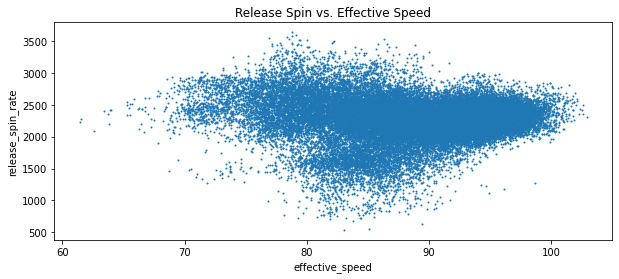

In [4]:
df.plot.scatter("effective_speed", "release_spin_rate", s=1, figsize=(10, 4), title="Release Spin vs. Effective Speed");

C:\Users\mgy0003\AppData\Local\Temp\ipykernel_20388\3529190843.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"]="blue"


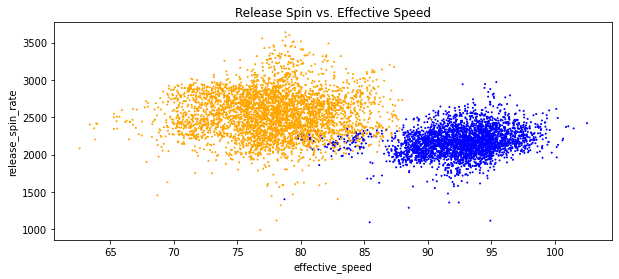

In [5]:
# Ok, this gives us some rough parameters for discussion. We see everything sort of clumped together,
# and there doesn't seem to be a huge trend other than when we have fast pitches they tend to have a
# spin rate which is homogeonous, and when the pitches slow down a bit the spin rate can be more
# variable. Let's see this now colored by pitch type

# First we segment only for the pitches we are interested in, and just take out fastballs and curveballs
df=df[df["pitch_type"].isin(["FT","CU"])]
# Now let's set the color for the two, we'll use blue for fastballs and orange for curveballs
df["color"]="blue"
df.loc[df["pitch_type"]=="CU","color"]="orange"
# One last cleanup -- sometime there is missing data, because we've got a big dataset I'm just going
# to drop those observations, but you might want to impute data instead. I'm going to reduce our
# datraframe to just those columns of interest too
df=df[["effective_speed", "release_spin_rate", "color", "pitch_type"]]
df=df.dropna()
# Now let's plot this
df.plot.scatter("effective_speed", "release_spin_rate", s=1, c="color", figsize=(10, 4), 
                legend=True, title="Release Spin vs. Effective Speed");

Ok, this looks like something which is almost linearly separable! You can see that by reducing it to just these two classes of pitches we get one cluster which is high speed and we have another class of pitches which is lower speed (off speed). Usually we're interested in building models with many more features than two, but two dimensional plots make for a good demonstration. Perhaps confusing at first, I'll more formally denote each feature with a subscript, such as $x_1$ and $x_2$, and I'll describe the set of all features as the variable $X$. You don't have to use this notation, but it's common and will be used in the documentation for most machine learning libraries, including _sklearn_. At the same time, it's common to use the variable $\hat y$ to represent the output variable we are trying to classify.

Now remember, the goal of the SVM classifier is to find the optimal line, which in the more general terms we call a _hyperplane_, to distinguish between our data classes across all in $X$. This line is called the maximum or _large margin classifier_, and is thought of as a linear band which separates the two classes. This band is sometimes called a street, and the edges of the street are given by parallel lines which exist at the first points from each class which are closest to the line. These points are called the _support vectors_ and that's where SVMs get their name from.

In [7]:
# Let's see an example of this using sklearn. We're going to import the svm module so we can
# create a classifier using the SVC function
from sklearn import svm

# It turns out you can do more than just linear classifiers with sklearn, and we'll talk about that a bit
# later on, but right now we're going to create just a linear Support Vector Classifier
clf=svm.SVC(kernel='linear', random_state=1337)

# Now, I did something different here, and I set the random_state parameter to an arbitrary integer
# value. The value doesn't matter, but if you don't set it then randomness will be....random. :)
# If you set it, the randomness will be the same each time you run it, which helps with debugging, and
# will help when I want to show you things in the data

# Let's form our train and test set. I'm going to use some smaller data here.
df_pitches=df.loc[0:999]

# Now let's separate into X for our features and y for our target values
X_train=df_pitches[["effective_speed", "release_spin_rate"]].loc[0:499]
y_train=df_pitches["pitch_type"].loc[0:499]

# And we can do the same with our test set
X_test=df_pitches[["effective_speed", "release_spin_rate"]].loc[500:]
y_test=df_pitches["pitch_type"].loc[500:]

# Now the beauty of sklearn's API becomes obvious - we fit and evaluate the quality of this model
# just like we did with our logistic regression!
clf.fit(X_train, y_train).score(X_test, y_test)

1.0

Ok, we built a perfect classifier! Now, this is not very common, in practice, but in practice you're usually looking at a harder problem to solve where there is much more noise. One of the interesting things we can do from here is get the support vectors for the model - the items closest to the street, or the line which separates the two classes.

C:\Users\mgy0003\AppData\Local\Temp\ipykernel_20388\2680697354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitches["color"]="blue"


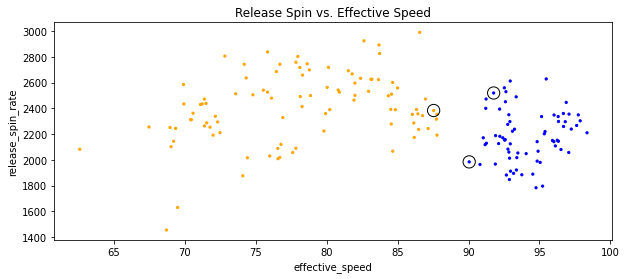

In [8]:
# So first we'll just plot our data points again, this time only looking at the pitch data we decided
# to play with in the model, and I'm going to make these points a bit bigger for our visual
df_pitches["color"]="blue"
df_pitches.loc[df_pitches["pitch_type"]=="CU","color"]="orange"
df_pitches.plot.scatter("effective_speed", "release_spin_rate", s=5, c="color", figsize=(10, 4), 
                        legend=True, title="Release Spin vs. Effective Speed");

# Now let's circle the support vectors. We get the support vector list from the model using the
# clf.support_vectors_ attribute, and I'm just going to create new data points which larger,
# transparent, but outlined at these locations
plt.gca().scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                  s=150,linewidth=1,facecolors="none",edgecolors="k");

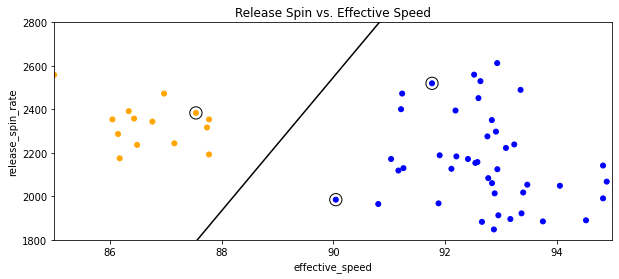

In [9]:
# I find this intereting, let's zoom in on the place where the support vectors are. First, let's
# plot our previous data.
df_pitches.plot.scatter("effective_speed", "release_spin_rate", s=25, c="color", figsize=(10, 4), 
                        legend=True, title="Release Spin vs. Effective Speed")
plt.gca().scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                  s=150,linewidth=1,facecolors="none",edgecolors="k")

# Here's a method to get the hyperplane for this set of vectors
def calculate_hyperplane(model):
    x_lim=plt.gca().get_xlim()
    y_lim=plt.gca().get_ylim()
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(x_lim[0], x_lim[1])
    yy = a * xx - (model.intercept_[0]) / w[1]
    return (xx,yy)

# Now we plot the hyperplane
plt.gca().plot( *calculate_hyperplane(clf), 'k-')

# And zoom in.
plt.xlim([85,95])
plt.ylim([1800,2800])

# And I'm just going to save this figure to a variable for later
fig = plt.gcf()

Look at this image for a moment. The support vectors are the points which are closest to the street. So, why are there some points closer? Think about how we tackled this problem and reflect for a moment.

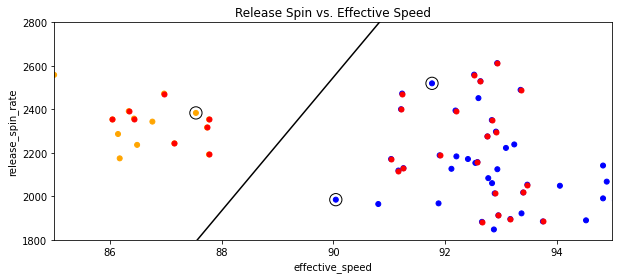

In [10]:
# Remember that for this we plotted all of the points in our dataset. But we only trained our model
# on a few of these, the first 500. Our test set has observations that our model hasn't been trained
# on, and most of the data points closest to the street actually happen to be in test set. That's
# ok, it shows our model was able to form good generalization, at least with respect to this particular
# data. We can see this by plotting just our test set in red and rendering the figure again.
X_test.plot.scatter("effective_speed", "release_spin_rate", s=25, c="red", ax=fig.axes[0])
fig

In [11]:
# I think it would be useful to see how the SVM is built up over time, so I want to create a little
# frame by frame animation. Remember that we need to see at least every class of data before we can
# train an SVM, so this means we need to sort the data so that fastballs and curballs appear at
# last as the first couple of entries in our DataFrame. Here's a bit of ugly code which does that
# and I'll store this sorted data into a new variable called observations
observations=df_pitches.groupby("pitch_type").apply(lambda x: x.reset_index(drop=True)).reset_index(0,drop=True).sort_index()
observations.head()

,effective_speed,release_spin_rate,color,pitch_type
0,84.651,2602.0,orange,CU
0,92.116,2127.0,blue,FT
1,83.118,2627.0,orange,CU
1,90.044,1985.0,blue,FT
2,81.793,2668.0,orange,CU


MovieWriter ffmpeg unavailable; using Pillow instead.


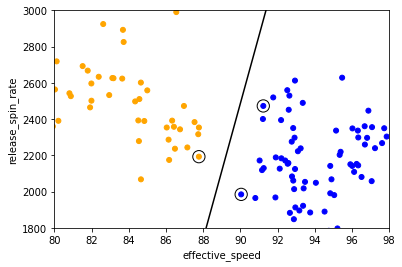

In [12]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots();

def fit_model(data):
    X=data[["effective_speed", "release_spin_rate"]]
    y=data["pitch_type"]
    return clf.fit(X,y)

def update(frame_num):
    """This function will be called to render each and every frame. Each frame will have different
    data in it (increasing over time), so this means we need to rebuild a model each time this
    function is called.
    :param frame_num: An integer offset of how many observations to use
    :return: The rendered matplotlib axes to plot
    """
    # First we clear whatever data is already plotted
    plt.cla()

    # Then we plot our current data
    observations[0:int(frame_num)+2].plot.scatter("effective_speed", "release_spin_rate", s=25, c="color", ax=ax)
    
    # Then we fit our model
    clf=fit_model(observations[0:int(frame_num)+2])

    # We plot our support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150,linewidth=1,facecolors="none",edgecolors="k")

    # We plot out hyperplane
    ax.plot(*calculate_hyperplane(clf), 'k-')

    # We need to set the bounds on this axes to something constant or the image will have a variable
    # (increasing) set of axes over time
    ax.set_xlim(80,98)
    ax.set_ylim(1800,3000)

    return ax.lines;

# Now I'm going to call this function and save it as an animated gif, let's build 350 models,
# but feel free to play with this on your notebook
anim = FuncAnimation(fig, update, frames=350, interval=25, blit=True);
anim.save('svm.gif', fps=5);

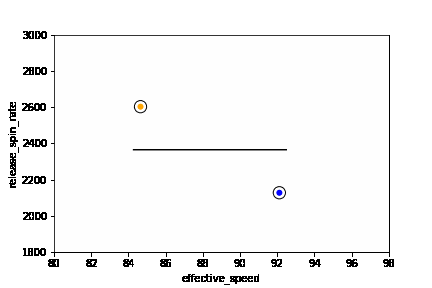

In [13]:
# Ok, let's take a look at that image now here in the notebook!
from IPython.display import Image
Image(filename="svm.gif")

Ok, you can see here that as more data is found the support vectors jump around and the street becomes more well defined and robust. The hyperplane then shifts and changes slope to better distinguish between these two feature sets. But this is just the basics of the SVM, there's a bit more we should consider when building these kinds of models, so let's dive into that in the next lecture.